In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import glob
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

In [2]:
CONSTANT = 13701
MAX_VALUE = 10000

In [3]:
CONSTANT//2

6850

In [4]:
def to_pair(a):
    return (a // MAX_VALUE, a % MAX_VALUE)
def to_num(a, b):
    return a * MAX_VALUE + b

In [5]:
def magic_fft(data):
    spec = fft(data)
            
    strt = 0
    stp = 10
    spec[strt:stp],spec[len(spec)-stp:len(spec)-strt] = np.zeros(stp - strt),np.zeros(stp - strt)
    
    strt = CONSTANT//2 - 6400
    stp = CONSTANT//2
    
    spec[strt:stp],spec[len(spec)-stp:len(spec)-strt] = np.zeros(stp - strt),np.zeros(stp - strt)

    return np.abs(ifft(spec) + np.mean(data))

In [6]:
def window(data,w):
    out = data
    
    for i in range(0,out.shape[0],w):
        d1,d2 = np.argmax(out[i:i+w]),np.max(out[i:i+w])
        out[i:i+w] = np.zeros_like(out[i:i+w])
        out[d1] = d2
        
        return(out)
    

In [7]:
def sorting(data,t):
    #sor = np.sort(data)[::-1]
    #sor[t::] = np.zeros_like(sor[t::]) 
    out = np.zeros_like(data)
    dummy = data
    for i in range(t):
        d1,d2 = np.argmax(dummy),np.max(dummy)
        out[d1] = d2
        dummy[d1] = 0
    return(out)
    

In [8]:
def fft_simple1(data):
    
    spec = fft(data)
    
    dummy = np.abs(spec[10:200])/np.max(np.abs(spec[10:200]))
    #return(np.log(dummy) + 10)
    dummy = sorting(dummy,20)
    return(dummy)

def fft_simple2(data):
    
    spec = fft(data)
    dummy = np.abs(spec[10:400])/np.max(np.abs(spec[10:400]))
    dummy = sorting(dummy,20)
    return(dummy)

In [9]:
def shift_resize(data):
    out = data - np.mean(data)
    if np.max(out) != 0:
        out = out/np.max(out)
    return(out)

In [10]:
def read_data(path, sz):
    kek = []
    anses = []
    for csv in glob.glob('{}/*.csv'.format(path)):
        tmp = np.array(pd.read_csv(csv, header=None))
        tmp = tmp[:sz]
        ans = tmp[0]
        tmp = tmp[1:]

        tmp = np.concatenate((fft_simple1(tmp[:,0]), fft_simple2(tmp[:,1])), axis=0)
        #tmp = np.concatenate((shift_resize(magic_fft(tmp[:,0])), shift_resize(magic_fft(tmp[:,1]))), axis=0)
        kek.append(tmp)
        anses.append(to_num(*ans))
    return np.array(kek), np.array(anses)

In [11]:
def gen_answer(path, ans, res_path):
    result = []
    for i, name in enumerate(glob.glob('{}/*.csv'.format(path))):
        sbp = min(max(to_pair(ans[i])), 1000)
        dbp = max(min(to_pair(ans[i])), 1)
        result.append([name.split('\\')[1], int(sbp), int(dbp)])
    pd.DataFrame(result).to_csv(res_path, index=False, header=False)

In [12]:
def get_scaler(data):
    scaler = StandardScaler()
    scaler.fit(data)  # Don't cheat - fit only on training data
    return scaler

def scale(scaler, data):
    return scaler.transform(data)

In [13]:
def PCA_basis(data):
    # apply PCA
    pca = PCA()
    pca.fit(data)
    components = pca.components_
    return(components)

In [15]:
matrix, labels = read_data('data_train', CONSTANT)
print(matrix.shape, labels.shape)


(894, 580) (894,)


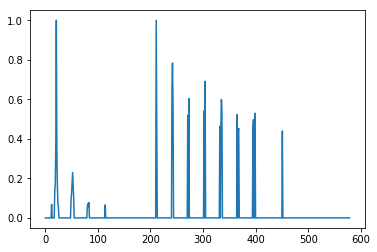

In [16]:
#plt.plot(matrix[12])
plt.plot(matrix[200])
plt.show()

In [17]:
#matr_basis = PCA_basis(matrix)

In [18]:
labels1 = np.array([to_pair(i)[0] for i in labels])
labels2 = np.array([to_pair(i)[1] for i in labels])

In [19]:
X_test1, tmptmp = read_data('data_test1_blank', CONSTANT)
print(X_test1.shape)


(362, 580)


In [20]:
#scaler = get_scaler(matrix)
#matrix = scale(scaler, matrix)
#X_test1 = scale(scaler, X_test1)

In [21]:
#enet1 = ElasticNet(alpha=0.1, l1_ratio= 0.8)
enet1 = KNeighborsRegressor(n_neighbors = 4)
y_pred_enet1 = enet1.fit(matrix, labels1).predict(X_test1)

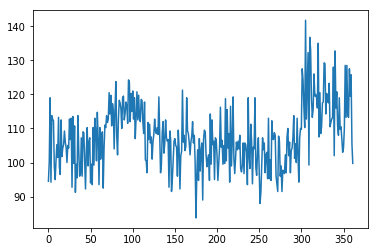

In [22]:
plt.plot(y_pred_enet1)
plt.show()

In [23]:
#enet2 = ElasticNet(alpha=0.8, l1_ratio= 0.1 )
enet2 = KNeighborsRegressor(n_neighbors = 4)
y_pred_enet2 = enet2.fit(matrix, labels2).predict(X_test1)

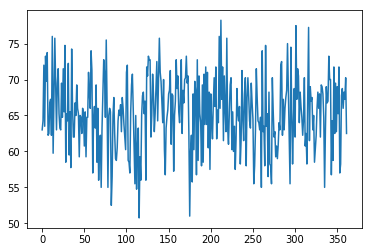

In [24]:
plt.plot(y_pred_enet2)
plt.show()

In [25]:
y_pred_enet = [to_num(int(y_pred_enet1[i]), int(y_pred_enet2[i])) for i in range(362)]

In [26]:
gen_answer('data_test1_blank', y_pred_enet, 'test1_result228.csv')

In [27]:
mm, L1 = read_data('data_test1_blank', CONSTANT)
print(mm.shape, L1.shape)

(362, 580) (362,)


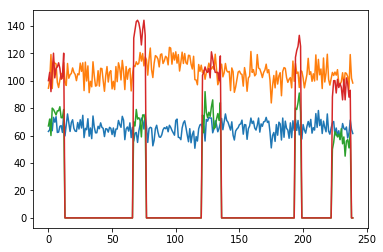

In [28]:
LL = to_pair(L1)
M = 240
plt.plot(y_pred_enet2[0:M])
plt.plot(y_pred_enet1[0:M])
plt.plot(LL[1][0:M])
plt.plot(LL[0][0:M])
plt.show()